<a href="https://colab.research.google.com/gist/shakasom/382a5cc0c59e24fdae29679de6d7e88a/crash-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Vehicle Accidents with Machine Learning - a Complete pipeline in Python.


Road accidents constitute a major problem in our societies around the world. The World Health Organization(WHO) estimated that 1.25 million deaths were related to road traffic injuries in the year 2010. For the year 2016, the USA alone had recorded 37, 461 motor vehicle crash-related deaths, averaging around 102 people per day. In Europe, the statistics also indicate that each minute, there are 50 road deaths recorded in the year 2017. Can machine learning help us understand the causes and the factors that affect car crash severity?

---

**New Zealand Crash Analysis Dastaset**
This data was extracted from the Transport Agency. Crash Analysis System (CAS). It is updated on a quarterly basis (Last update on October 2018). CAS records all traffic crashes as reported to the Transport Agency by the NZ Police. Not all crashes are reported to the NZ Police. The level of reporting increases with the severity of the crash. Due to the nature of non-fatal crashes it is believed that these are under-reported. CAS covers crashes on all New Zealand roadways or places where the public have legal access with a motor vehicle. Data is currently available from 1 January 2000 and is updated quarterly. The dataset includes crash variables confirmed as non-personal data.


---

In this notebook, we will do a complete machine learning pipeline from getting data programmatically, performing exploratory data analysis and formulating a real-world problem into a machine learning model and interpreting the results. The complete code and Jupyter notebooks are available in this Github repo. The whole process is carried out in Google Colab using their free TPU environment so you can directly open the notebook and experiment it.






## Installation

We need to install first some libraries not preinstalled in Google Colab, so let us do that.

In [0]:
%%time 
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install folium 
!pip install pysal
!pip install scipy
!pip install -U scikit-learn
!pip install seaborn --upgrade


In [0]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import requests
import seaborn as sns

print(sns.__version__)

0.9.0


* Restart runtime and only import libraries again to get Seaborn 0.9.1. No installation needed again. Continue to the next section. 

## Getting the Data

The Crash Analysis System (CAS) data is available in different formats and APIs. It is simple to grab them through API interfaces, instead of downloading to your local machine. This is beneficial, as we will access latest updated data every time we run the Jupyter notebook. I find this particular problem, the vehicle accidents, to be strongly related to location (Geography), so we will grab the geojson, instead of usual csv file, so that we can perform geographic data analysis without creating geometries from latitude and longtitude and deal with coordinate reference systems and projections. 

We will use Geopandas library to read the data. If you are familiar with Pandas library, then you should feel home as Geopandas is built on top pandas. Geopandas is high level library that makes working with geographic data in Python easier as it allows pandas functionality and data types to allow spatial operations on geographic geometries. It is well integrated with the python echosystem and depends much on pandas, matplotlib and shapely library for geometric operations.

In [0]:
# Get the data from url and request it as json file
url = 'https://opendata.arcgis.com/datasets/a163c5addf2c4b7f9079f08751bd2e1a_0.geojson'
geojson = requests.get(url).json()

In [0]:
# Read the data as GeodataFrame in Geopandas
crs = {'init': 'epsg:3851'} # Coordinate reference system (CRS) for Newzealand
gdf = gpd.GeoDataFrame.from_features(geojson['features'], crs=crs)

In [0]:
gdf.head()


,OBJECTID,Pedestrian,advisorySpeed,animals,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,...,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1001,1,0,0,514200,0,0,0,0,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
1,1002,0,0,0,514102,0,0,0,2,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
2,1003,0,0,0,514103,0,0,0,2,0,...,0,0,0,0,Urban,0,0,0,Light Rain,Unknown
3,1004,0,0,0,517703,0,0,0,2,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
4,1005,0,0,0,517702,1,0,0,1,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown


In [0]:
gdf.shape

(665847, 88)

## Exploratoray Data Analysis (EDA)

### Crash 

**crashSeverity**: The severity of a crash. Possible values are 'F' (fatal), 'S' (serious), 'M' (minor), 'N' (non-injury). This is determined by the worst injury sustained in the crash at time of entry.

**seriousInjuryCount**: A count of the number of serious injuries (inj) associated with this crash.

**minorInjuryCount**: A count of the number of minor injuries (inj) associated with this crash.

**fatalCount:** A count of the number of fatal casualties associated with this crash.

In [0]:
#@title 
from IPython.display import Image
from IPython.core.display import HTML 

start_year = gdf.crashYear.min()
end_year = gdf.crashYear.max()

fatal = gdf['fatalCount'].sum()
major = gdf['seriousInjuryCount'].sum()
minor = gdf['minorInjuryCount'].sum()

print("The total death in car crash accidents since the year {}, up to {} is {}.".format(start_year, end_year,fatal))
print("While the total number of serious injuries and minor injuries in car accidents reach {}, {} respectively".format(major,minor))
#respectively in the same period".format(start_year, end_year,fatal, minor, major))


Image(url= "https://images.unsplash.com/photo-1542092444-400d92b09cea?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1352&q=80")

The total death in car crash accidents since the year 2000, up to 2018 is 6922.
While the total number of serious injuries and minor injuries in car accidents reach 45044, 205895 respectively


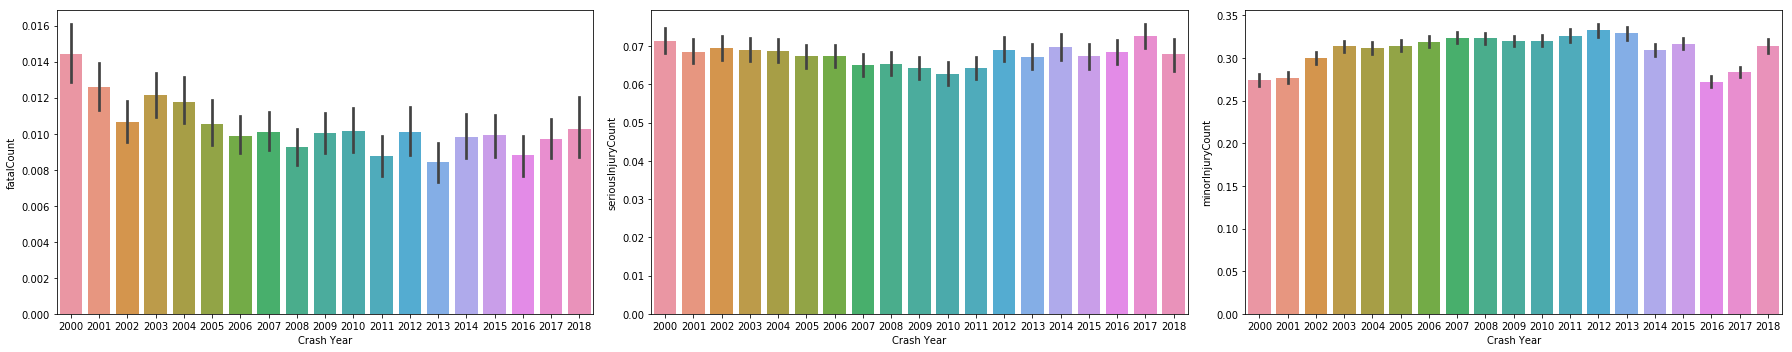

In [0]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5));

sns.barplot(x="crashYear", y="fatalCount",  data=gdf, ax=ax[0]);
sns.barplot(x="crashYear", y="seriousInjuryCount",  data=gdf, ax=ax[1]);
sns.barplot(x="crashYear", y="minorInjuryCount",  data=gdf, ax=ax[2]);
[ax[i].set_xlabel('Crash Year') for i in range(3)]
plt.tight_layout()

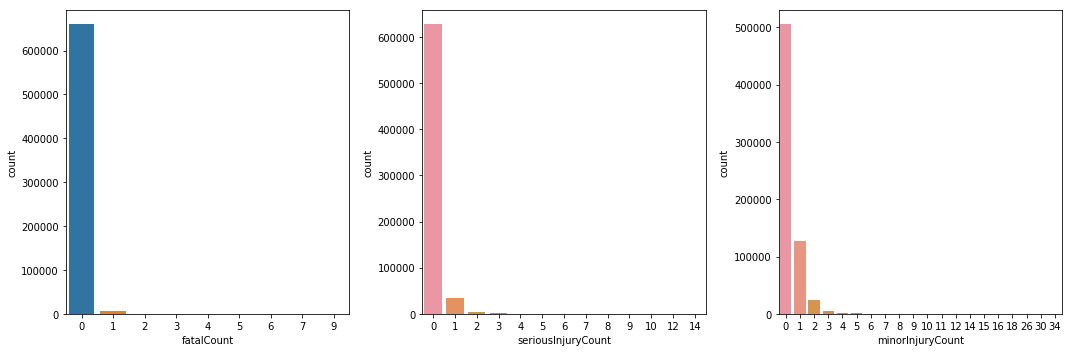

In [0]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5));
sns.countplot(x="fatalCount",data=gdf, ax=ax[0])
sns.countplot(x="seriousInjuryCount",data=gdf, ax=ax[1])
sns.countplot(x="minorInjuryCount",data=gdf, ax=ax[2]);
#ax.set_xlabel('Crash Year', fontsize=10)
plt.tight_layout()

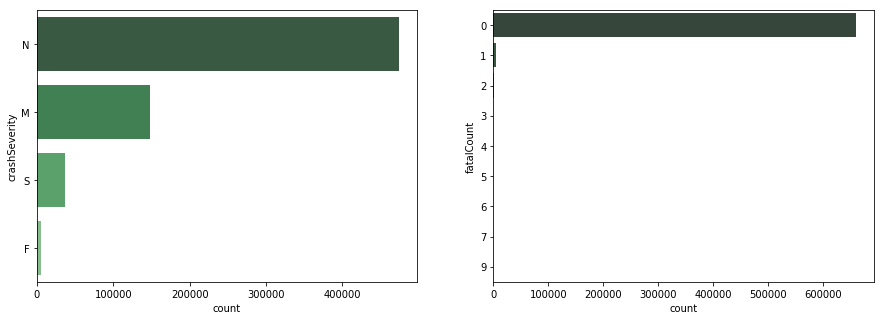

In [0]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));
sns.countplot(y="crashSeverity",data=gdf, palette="Greens_d", order='NMSF',ax = ax[0]);
sns.countplot(y="fatalCount",data=gdf, palette="Greens_d", ax=ax[1]);

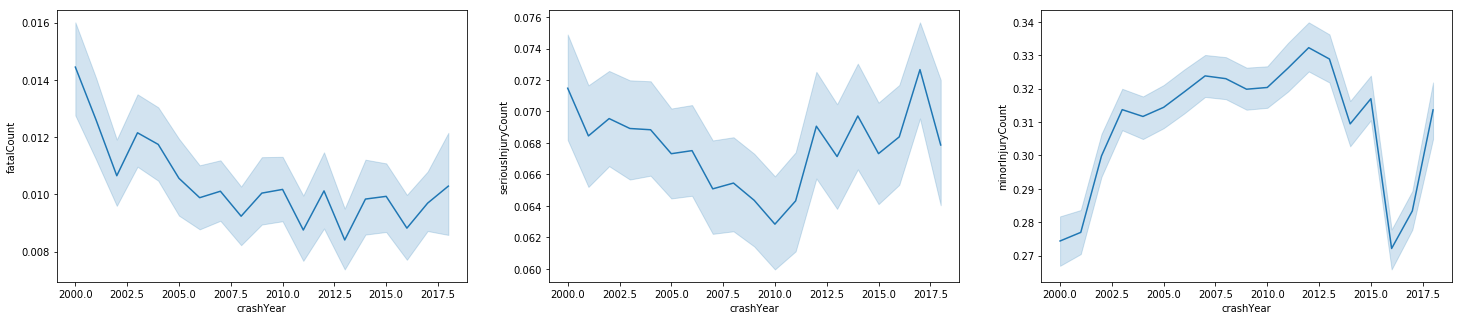

In [0]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5));
sns.lineplot(x="crashYear", y="fatalCount",data=gdf, ax=ax[0]);
sns.lineplot(x="crashYear", y="seriousInjuryCount",data=gdf, ax=ax[1]);
sns.lineplot(x="crashYear", y="minorInjuryCount",data=gdf, ax=ax[2]);

### Roads 


roadworks, 
roadCharacter
roadCurvature
roadLane
roadMarkings
roadSurface
roadWet
numberOfLanes
intersectionintersectionMidblock
 flatHill
 darkLight

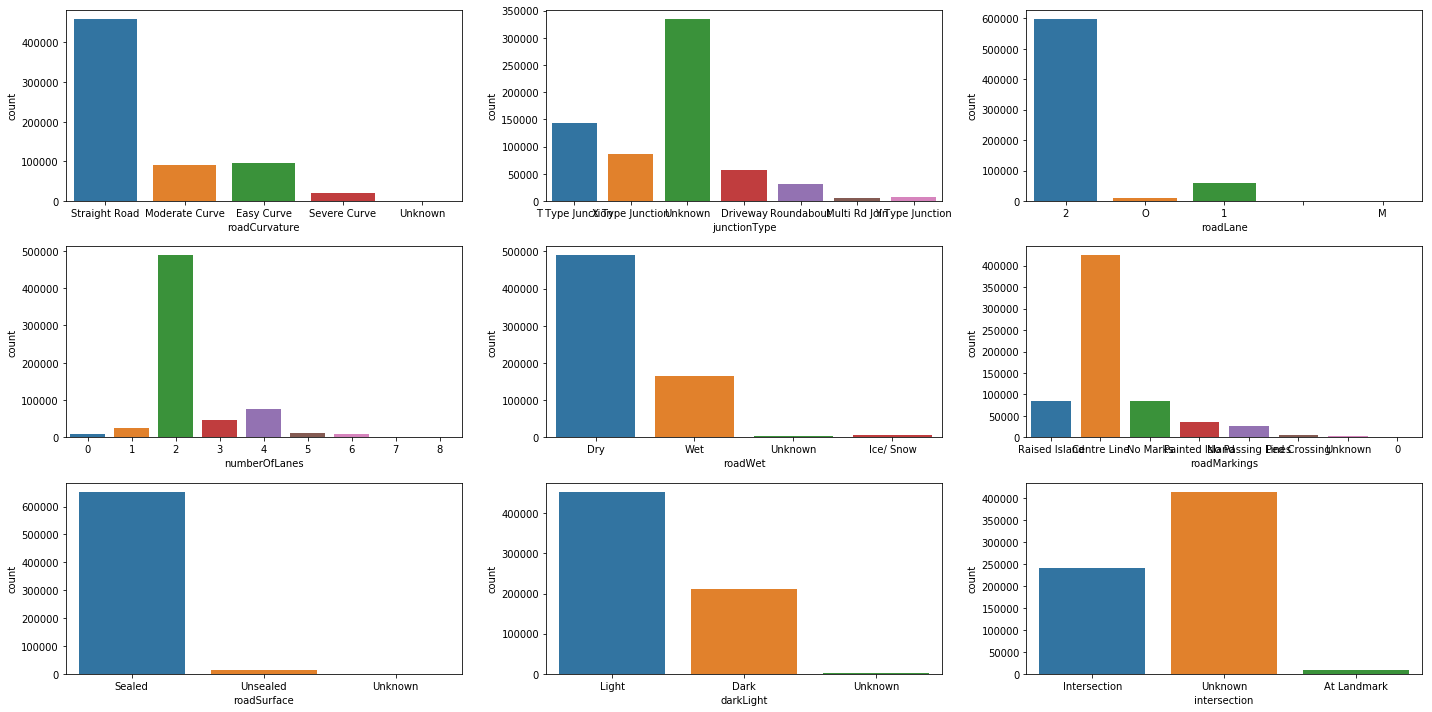

In [0]:
fig, ax = plt.subplots(3, 3, figsize = (20, 10));

sns.countplot(x='roadCurvature',data=gdf, ax=ax[0,0])
sns.countplot(x="junctionType",data=gdf,  ax=ax[0,1])
sns.countplot(x='roadLane',data=gdf, ax=ax[0,2])
sns.countplot(x='numberOfLanes',data=gdf, ax=ax[1,0])
sns.countplot(x='roadWet',data=gdf, ax=ax[1,1])
sns.countplot(x='roadMarkings',data=gdf,  ax=ax[1,2])
sns.countplot(x='roadSurface',data=gdf, ax=ax[2,0])
sns.countplot(x='darkLight',data=gdf, ax=ax[2,1])
sns.countplot(x='intersection',data=gdf, ax=ax[2,2])
#intersectionMidblock
plt.tight_layout()


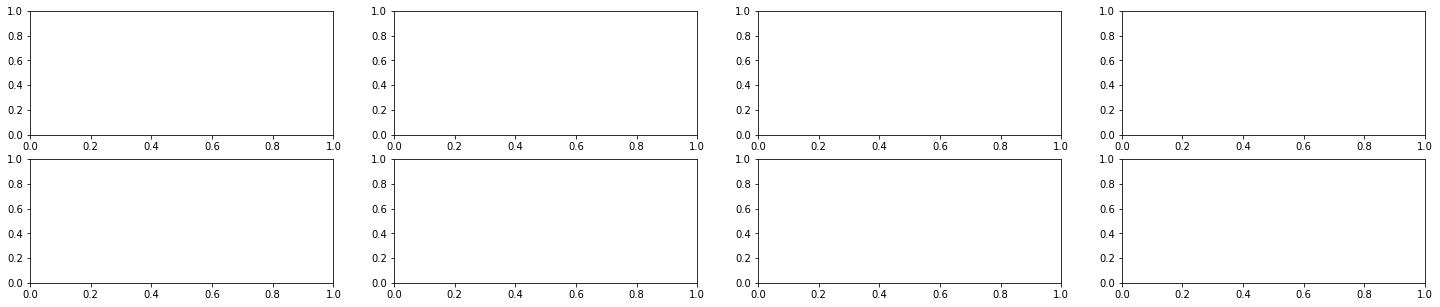

In [0]:

fig, ax = plt.subplots(2, 4, figsize = (25, 5));

#sns.barplot(x='roadCurvature',data=gdf, palette="Reds_d", ax=ax[0,0])
#sns.barplot(x="junctionType",data=gdf, palette="Greens_d", ax=ax[0,1])
#sns.barplot(x='roadLane',data=gdf, palette="Reds_d", ax=ax[0,2])
#sns.barplot(x='numberOfLanes',data=gdf, palette="Reds_d", ax=ax[0,3])
#sns.barplot(x='roadWet',data=gdf, palette="Reds_d", ax=ax[1,0])
#sns.barplot(x='roadMarkings',data=gdf, palette="Reds_d", ax=ax[1,1])
#sns.barplot(x='roadSurface',data=gdf, palette="Reds_d", ax=ax[1,2])
#sns.barplot(x='darkLight',data=gdf, palette="Reds_d", ax=ax[1,3])
#plt.tight_layout()

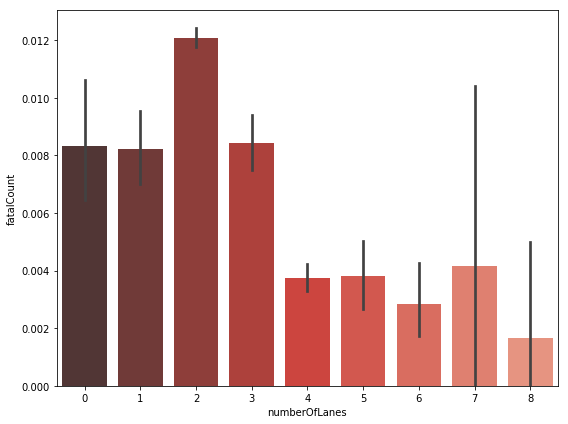

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(x='numberOfLanes',y = 'fatalCount',data=gdf, palette="Reds_d")
plt.tight_layout();

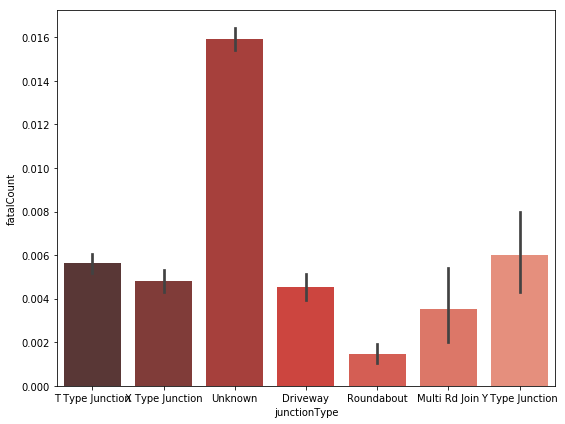

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(x='junctionType',y = 'fatalCount',data=gdf, palette="Reds_d")
plt.tight_layout()

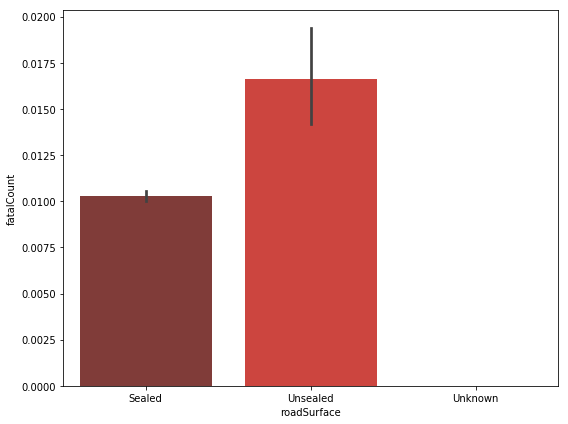

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(x='roadSurface',y = 'fatalCount',data=gdf, palette="Reds_d")
plt.tight_layout()

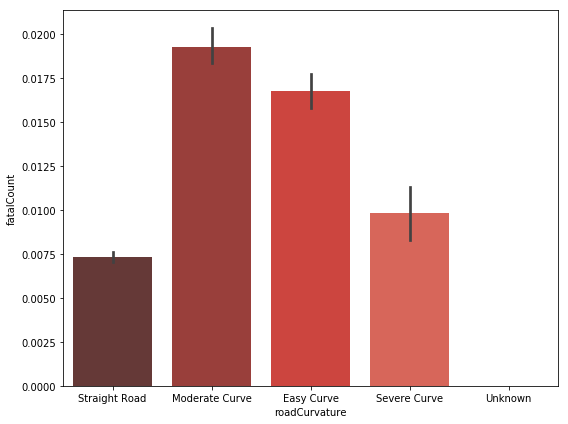

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(x='roadCurvature',y = 'fatalCount',data=gdf, palette="Reds_d")
plt.tight_layout()

### Trafic

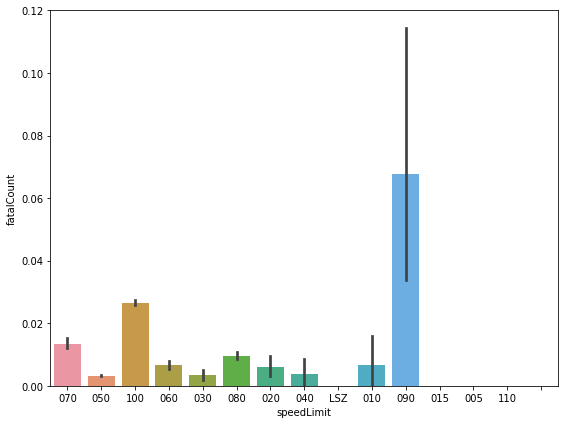

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(x="speedLimit", y="fatalCount",  data=gdf);
plt.tight_layout()

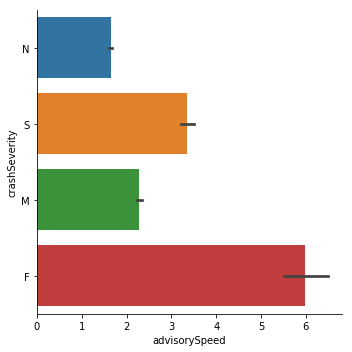

In [0]:
sns.catplot(x="advisorySpeed", y="crashSeverity",data=gdf, kind= 'bar');

### Weather

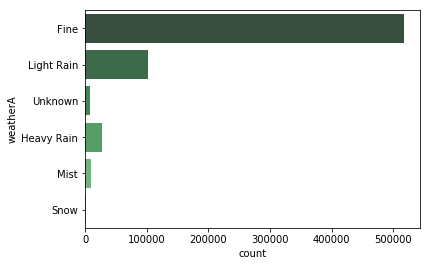

In [0]:
sns.countplot(y="weatherA",data=gdf, palette="Greens_d");


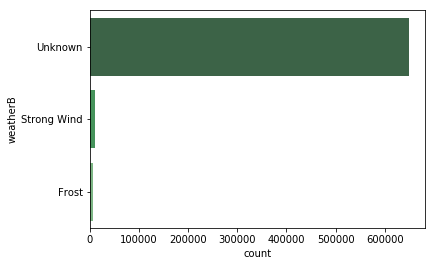

In [0]:
sns.countplot(y="weatherB",data=gdf, palette="Greens_d");

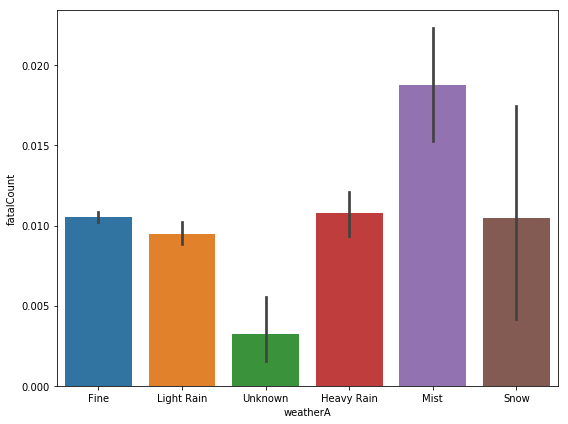

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(x="weatherA", y="fatalCount",  data=gdf);
plt.tight_layout()

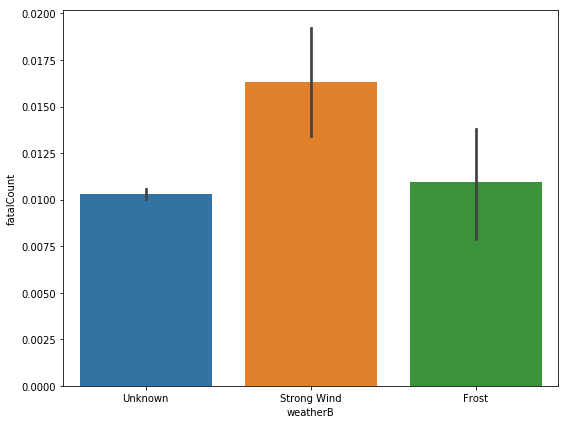

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(x="weatherB", y="fatalCount",  data=gdf);
plt.tight_layout()

### Pearson Correlation

In [0]:
selected_cols = ['weatherA', 'weatherB','speedLimit','fatalCount', "advisorySpeed", 
                     'roadCurvature', 'roadLane', 'numberOfLanes' ]

In [0]:
# This might take a while so skip !
k = 10 
f,ax = plt.subplots(figsize=(12, 12))
cols = gdf.corr().nlargest(k, 'fatalCount')['fatalCount'].index
cm = np.corrcoef(gdf[selected_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
#plt.show()

## Geographic Data Exploration

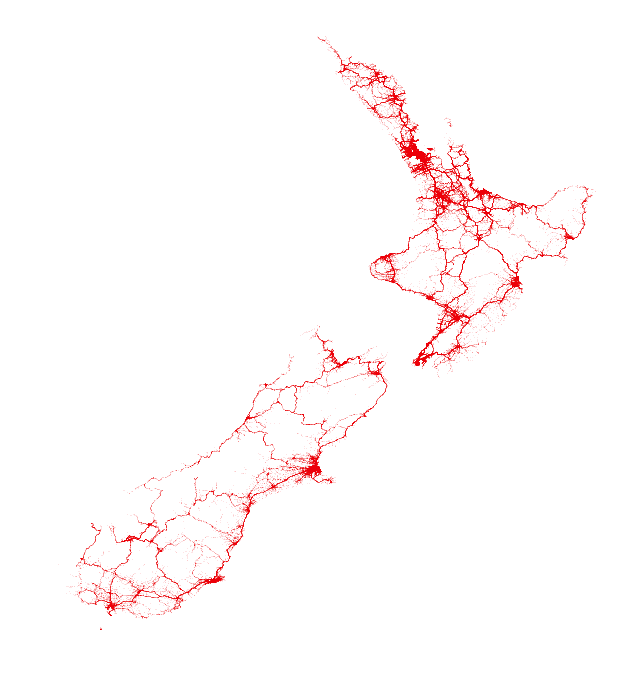

In [0]:
gdf.plot(markersize=0.01, edgecolor='red',figsize=(12,12));
plt.axis('off');

In [36]:
from folium.plugins import MarkerCluster
gdf_sample = gdf.sample(5000)
lons = gdf_sample.geometry.x
lats = gdf_sample.geometry.y

m = folium.Map(
    location=[np.mean(lats), np.mean(lons)],
    tiles='Cartodb Positron',
    zoom_start=6
)

#FastMarkerCluster(data=list(zip(lats, lons))).add_to(m)
MarkerCluster(list(zip(lats, lons))).add_to(m)

folium.LayerControl().add_to(m)
m


In [37]:
gdf_sample = gdf.sample(5000)
lons = gdf_sample.geometry.x
lats = gdf_sample.geometry.y
heat_cols = list(zip(lats, lons))
from folium.plugins import HeatMap

m = folium.Map([np.mean(lats), np.mean(lons)], 
               tiles='CartoDB dark_matter', 
               zoom_start=6)

HeatMap(heat_cols).add_to(m)
m


## Machine Learning Model

We can approach the modeling part of this problem in different ways. We could take it as regression problem and predict the number of fatalities based on the attributes of the crash dataset. We can also approach it as classification problem and predict the severity of the crash based on the crash dataset. In this example, I will approach it as a regression problem. Feel free to build a classification model if you want to give it a try. It will basically be the same approach. I will not do any feature engineering in this case, I think the attributes we have are enough to build a baseline, and we can always revisit this and do feature engineering later to boost our model accuracy.

---

In that case, we will use fatalCount as the dependent variable (y) and all other attributes as dependent variables. I normally use Randome Forest for most of my machine learning models. It needs only minimal data preprocessing and does well in a many datasets. So let us try Random Forest!

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [0]:
gdf.head()

,OBJECTID,Pedestrian,advisorySpeed,animals,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,...,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1001,1,0,0,514200,0,0,0,0,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
1,1002,0,0,0,514102,0,0,0,2,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
2,1003,0,0,0,514103,0,0,0,2,0,...,0,0,0,0,Urban,0,0,0,Light Rain,Unknown
3,1004,0,0,0,517703,0,0,0,2,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
4,1005,0,0,0,517702,1,0,0,1,0,...,0,0,0,0,Urban,0,0,0,Fine,Unknown


In [0]:
# Let us change our data into a dataframe. I suspect most models will not work with GeoDataframe and Geometry Column
df = pd.DataFrame(gdf.drop(['geometry','OBJECTID'], axis = 1))
df.head()

,Pedestrian,advisorySpeed,animals,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,cornerRoadSideRoad,...,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1,0,0,514200,0,0,0,0,0,1,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
1,0,0,0,514102,0,0,0,2,0,1,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
2,0,0,0,514103,0,0,0,2,0,1,...,0,0,0,0,Urban,0,0,0,Light Rain,Unknown
3,0,0,0,517703,0,0,0,2,0,1,...,0,0,0,0,Urban,0,0,0,Fine,Unknown
4,0,0,0,517702,1,0,0,1,0,1,...,0,0,0,0,Urban,0,0,0,Fine,Unknown


### Random Forest

We need to convert the categorical variables into numerical variables. 

In [0]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
lblE = LabelEncoder()
for i in df:
    if df[i].dtype == 'object':
        lblE.fit(df[i])
        df[i] = lblE.transform(df[i])

In [0]:
# One Hot Encoding
df = pd.get_dummies(df)

In [0]:
df.head()

,Pedestrian,advisorySpeed,animals,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,cornerRoadSideRoad,...,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,1,0,0,514200,0,0,0,0,0,1,...,0,0,0,0,2,0,0,0,0,2
1,0,0,0,514102,0,0,0,2,0,1,...,0,0,0,0,2,0,0,0,0,2
2,0,0,0,514103,0,0,0,2,0,1,...,0,0,0,0,2,0,0,0,2,2
3,0,0,0,517703,0,0,0,2,0,1,...,0,0,0,0,2,0,0,0,0,2
4,0,0,0,517702,1,0,0,1,0,1,...,0,0,0,0,2,0,0,0,0,2


In [0]:
# Let us split our data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('fatalCount', axis=1), 
                                                    df.fatalCount, test_size=0.33, random_state=42)

In [0]:
#shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((446117, 85), (219730, 85), (446117,), (219730,))

In [0]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), 
           m.score(X_test, y_test)]
    
    if hasattr(m, 'oob_score_'):res.append(m.oob_score_)
    print (res)

In [0]:
m = RandomForestRegressor(n_estimators=50)

In [0]:
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
print_score(m)

[0.018344500225379028, 0.043443651316007775, 0.9753479582370266, 0.8606575480807965]


#### Feature Importance

In [0]:
f_imp = pd.DataFrame(data={'importance':m.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp = f_imp.sort_values('importance', ascending=False)
f_imp.head(10)


,importance
features,
crashSeverity,0.856234
crashLocation2,0.012054
easting,0.007496
crashRPDisplacement,0.007479
crashDistance,0.006470
crashRPRS,0.006240
seriousInjuryCount,0.006006
crashYear,0.005774
northing,0.005449


Clearly, crash severity is highly important in this model. This column is derived from the number fatalities, therefore the relationship

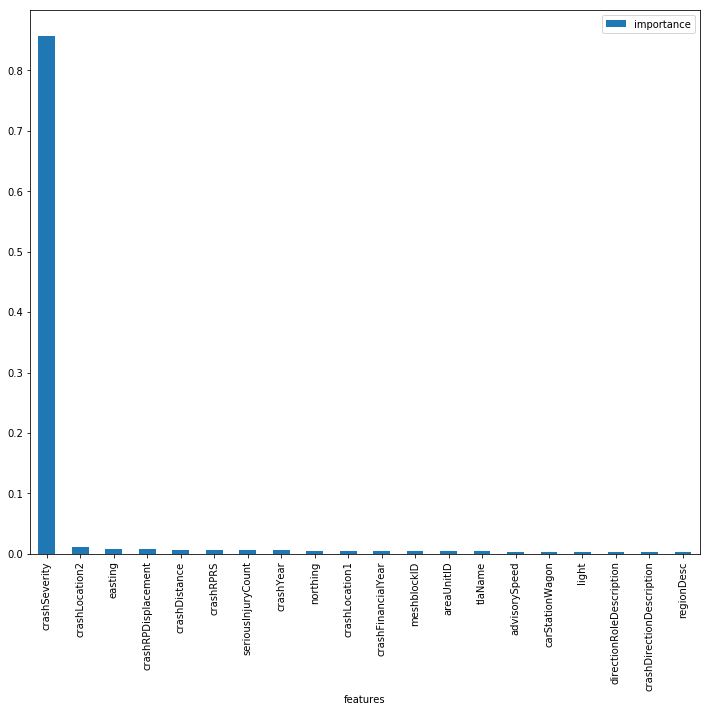

In [0]:
f_imp[:20].plot(kind='bar', figsize=(12,10))


In [0]:
f_imp_sel = f_imp[f_imp['importance'] > 0.0001]

In [0]:
len(f_imp_sel.index), len(f_imp.index)

(72, 85)

In [0]:
y = df.fatalCount

In [0]:
df_imp = df[f_imp_sel.index]
df_imp.shape

(665847, 72)

In [0]:
# Let us split our data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(df_imp, y, test_size=0.33, random_state=42)

In [0]:
m = RandomForestRegressor(n_estimators=50, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
print_score(m)

[0.017095813138420905, 0.0434211226536629, 0.9785898036358827, 0.8608020288048663, 0.8357534668534298]


In [0]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.03346640554195113, 0.041734956446513746, 0.9179536500737805, 0.8714030291232601, 0.8485239393846815]


In [0]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.03787103628184791, 0.04148310190961803, 0.8949356194894301, 0.8729504133545137, 0.8532111943543574]


In [0]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04110210623358099, 0.041335904044904864, 0.8762431402769002, 0.8738504544367234, 0.8558830062254443]


In [0]:

m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, max_features= 0.5,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.041287795510941805, 0.0412720933131686, 0.8751224078521291, 0.8742396309548686, 0.8559869026088301]


In [0]:
m = RandomForestRegressor(n_estimators=50, min_samples_leaf=25, max_features= 0.5, min_samples_split=0.1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04823867593641789, 0.04579174812436444, 0.8295363107504776, 0.8451877736984046, 0.8260071291772664]


In [0]:
from sklearn.ensemble import ExtraTreesRegressor

# END 